In [39]:
# !pip install torch
# !pip install torchvision
# !pip install transformers
# !pip install easyocr

In [40]:
import csv
import easyocr
import numpy as np
import pandas as pd
import torch

from PIL import Image, ImageDraw
from torchvision import transforms
from transformers import TableTransformerForObjectDetection
from tqdm import tqdm

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
structure_model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-structure-recognition-v1.1-all")
structure_model.to(device)
structure_model

TableTransformerForObjectDetection(
  (model): TableTransformerModel(
    (backbone): TableTransformerConvModel(
      (conv_encoder): TableTransformerConvEncoder(
        (model): ResNetBackbone(
          (embedder): ResNetEmbeddings(
            (embedder): ResNetConvLayer(
              (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (normalization): TableTransformerFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          )
          (encoder): ResNetEncoder(
            (stages): ModuleList(
              (0): ResNetStage(
                (layers): Sequential(
                  (0): ResNetBasicLayer(
                    (shortcut): Identity()
                    (layer): Sequential(
                      (0): ResNetConvLayer(
                        (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(

In [4]:
class MaxResize(object):
    def __init__(self, max_size=800):
        self.max_size = max_size

    def __call__(self, image):
        width, height = image.size
        current_max_size = max(width, height)
        scale = self.max_size / current_max_size
        resized_image = image.resize((int(round(scale*width)), int(round(scale*height))))

        return resized_image

In [5]:
structure_transform = transforms.Compose([
    MaxResize(1000),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406], 
        [0.229, 0.224, 0.225]
    )
])

In [6]:
cropped_table = Image.open("example1.jpg").convert("RGB")

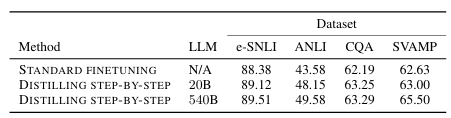

In [7]:
cropped_table

In [8]:
pixel_values = structure_transform(cropped_table).unsqueeze(0)
pixel_values = pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 262, 1000])


In [9]:
# forward pass
with torch.no_grad():
    outputs = structure_model(pixel_values)

In [10]:
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def outputs_to_objects(outputs, img_size, id2label):
    m = outputs.logits.softmax(-1).max(-1)
    pred_labels = list(m.indices.detach().cpu().numpy())[0]
    pred_scores = list(m.values.detach().cpu().numpy())[0]
    pred_bboxes = outputs['pred_boxes'].detach().cpu()[0]
    pred_bboxes = [elem.tolist() for elem in rescale_bboxes(pred_bboxes, img_size)]

    objects = []
    for label, score, bbox in zip(pred_labels, pred_scores, pred_bboxes):
        class_label = id2label[int(label)]
        if not class_label == 'no object':
            objects.append({
                'label': class_label, 
                'score': float(score),
                'bbox': [float(elem) for elem in bbox]
            })

    return objects

In [11]:
# update id2label to include "no object"
structure_id2label = structure_model.config.id2label
structure_id2label[len(structure_id2label)] = "no object"

cells = outputs_to_objects(outputs, cropped_table.size, structure_id2label)
print(cells)

[{'label': 'table column', 'score': 0.9998883008956909, 'bbox': [178.81324768066406, 15.409523963928223, 226.68125915527344, 105.89593505859375]}, {'label': 'table spanning cell', 'score': 0.999355137348175, 'bbox': [16.76546859741211, 15.448320388793945, 178.65077209472656, 57.019107818603516]}, {'label': 'table column', 'score': 0.9999485015869141, 'bbox': [335.4537048339844, 15.638177871704102, 383.7980651855469, 105.91840362548828]}, {'label': 'table spanning cell', 'score': 0.6768660545349121, 'bbox': [226.69107055664062, 15.42088508605957, 438.0879211425781, 34.005069732666016]}, {'label': 'table spanning cell', 'score': 0.9941124320030212, 'bbox': [178.59542846679688, 15.517037391662598, 226.7539825439453, 56.8170051574707]}, {'label': 'table column header', 'score': 0.9986922144889832, 'bbox': [16.90447235107422, 15.407608985900879, 437.3479919433594, 56.86110305786133]}, {'label': 'table column', 'score': 0.9998703002929688, 'bbox': [286.08221435546875, 15.546051979064941, 335

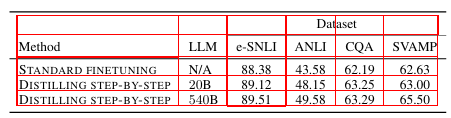

In [12]:
cropped_table_visualized = cropped_table.copy()
draw = ImageDraw.Draw(cropped_table_visualized)

for cell in cells:
    draw.rectangle(cell["bbox"], outline="red")

cropped_table_visualized

In [13]:
def get_cell_coordinates_by_row(table_data):
    # Extract rows and columns
    rows = [entry for entry in table_data if entry['label'] == 'table row']
    columns = [entry for entry in table_data if entry['label'] == 'table column']

    # Sort rows and columns by their Y and X coordinates, respectively
    rows.sort(key=lambda x: x['bbox'][1])
    columns.sort(key=lambda x: x['bbox'][0])

    # Function to find cell coordinates
    def find_cell_coordinates(row, column):
        cell_bbox = [
            column['bbox'][0], 
            row['bbox'][1], 
            column['bbox'][2], 
            row['bbox'][3]
        ]
        return cell_bbox

    # Generate cell coordinates and count cells in each row
    cell_coordinates = []

    for row in rows:
        row_cells = []
        for column in columns:
            cell_bbox = find_cell_coordinates(row, column)
            row_cells.append({
                'column': column['bbox'], 
                'cell': cell_bbox
            })

        # Sort cells in the row by X coordinate
        row_cells.sort(key=lambda x: x['column'][0])

        # Append row information to cell_coordinates
        cell_coordinates.append({
            'row': row['bbox'], 
            'cells': row_cells, 
            'cell_count': len(row_cells)
        })

    # Sort rows from top to bottom
    cell_coordinates.sort(key=lambda x: x['row'][1])

    return cell_coordinates

cell_coordinates = get_cell_coordinates_by_row(cells)

In [14]:
reader = easyocr.Reader(['en']) # this needs to run only once to load the model into memory

def apply_ocr(cell_coordinates):
    # let's OCR row by row
    data = dict()
    max_num_columns = 0
    for idx, row in enumerate(tqdm(cell_coordinates)):
        row_text = []
        for cell in row["cells"]:
            # crop cell out of image
            cell_image = np.array(cropped_table.crop(cell["cell"]))
            # apply OCR
            result = reader.readtext(np.array(cell_image))
            if len(result) > 0:
                text = " ".join([x[1] for x in result])
                row_text.append(text)

        if len(row_text) > max_num_columns:
            max_num_columns = len(row_text)

        data[idx] = row_text

    print("Max number of columns:", max_num_columns)

    # pad rows which don't have max_num_columns elements
    # to make sure all rows have the same number of columns
    for row, row_data in data.copy().items():
        if len(row_data) != max_num_columns:
            row_data = row_data + ["" for _ in range(max_num_columns - len(row_data))]
        data[row] = row_data

    return data

data = apply_ocr(cell_coordinates)

for row, row_data in data.items():
    print(row_data)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.
100%|██████████| 5/5 [28:38<00:00, 343.76s/it]

Max number of columns: 6
['Dat', 'ASCl', '', '', '', '']
['Method', 'LLM', 'SNLI', 'ANLI', 'CQA', 'SVAMP']
['STANDARD FINETUNING', 'NYA', '88.38', '43.58', '62.19', '62.63']
['DISTILLING STEP-BY-STEP', '20B', '89.12', '48.15', '63.25', '63.00']
['DISTILLING STEP-BY-STEP', '54OB', '89.51', '49.58', '63.29', '65.50']


In [36]:
list(data.values())

[['Dat', 'ASCl', '', '', '', ''],
 ['Method', 'LLM', 'SNLI', 'ANLI', 'CQA', 'SVAMP'],
 ['STANDARD FINETUNING', 'NYA', '88.38', '43.58', '62.19', '62.63'],
 ['DISTILLING STEP-BY-STEP', '20B', '89.12', '48.15', '63.25', '63.00'],
 ['DISTILLING STEP-BY-STEP', '54OB', '89.51', '49.58', '63.29', '65.50']]